In [1]:
from LRL import *

## Environment

In [2]:
import gym

Для использования $V$-функции вместо $Q$-функции понадобилась необходимость "в торче" искать все возможные следующие состояния для батча кубиков, поэтому пришлось писать вспомогательный класс:

In [3]:
class BatchOfRubiks:
    def __init__(self, groups):
        self.group = groups
        
    def forward_cycle(self, a, b, c, d):
        self.group[:, a-1], self.group[:, b-1], self.group[:, c-1], self.group[:, d-1] = \
        self.group[:, d-1].clone(), self.group[:, a-1].clone(), self.group[:, b-1].clone(), self.group[:, c-1].clone()
        return self
    
    def backward_cycle(self, a, b, c, d):
        self.group[:, a-1], self.group[:, b-1], self.group[:, c-1], self.group[:, d-1] = \
        self.group[:, b-1].clone(), self.group[:, c-1].clone(), self.group[:, d-1].clone(), self.group[:, a-1].clone()
        return self

    def rotate(self, command):
        self.cycle = self.forward_cycle if command < 6 else self.backward_cycle
        command = command % 6
        
        if command == 0:
            self.cycle(1,3,8,6).cycle(2,5,7,4).cycle(33,9,41,32).cycle(36,12,44,29).cycle(38,14,46,27)
        elif command == 1:
            self.cycle(9,11,16,14).cycle(10,13,15,12).cycle(38,17,43,8).cycle(39,20,42,5).cycle(40,22,41,3)
        elif command == 2:
            self.cycle(17,19,24,22).cycle(18,21,23,20).cycle(48,16,40,25).cycle(45,13,37,28).cycle(43,11,35,30)
        elif command == 3:
            self.cycle(25,27,32,30).cycle(26,29,31,28).cycle(19,33,6,48).cycle(21,34,4,47).cycle(24,35,1,46)
        elif command == 4:
            self.cycle(33,35,40,38).cycle(34,37,39,36).cycle(25,17,9,1).cycle(26,18,10,2).cycle(27,19,11,3)
        elif command == 5:
            self.cycle(41,43,48,46).cycle(42,45,47,44).cycle(6,14,22,30).cycle(7,15,23,31).cycle(8,16,24,32)
        return self

def next_states(states):
    ns = torch.cat([BatchOfRubiks(states.clone()).rotate(i).group[:, None] for i in range(12)], dim=1)
    done = ((ns != Tensor([0]*8 + [1]*8 + [2]*8 + [3]*8 + [4]*8 + [5]*8)).sum(dim=2) > 0).type(torch.cuda.FloatTensor)
    return ns, Tensor(states.size()[0], 12).zero_() - 1, 1 - done

Сама среда. Награда: -1 всегда.
* complexity: сколько раз к собранному кубику применяется рандомное действие при ресете.
* limit: после такого числа ходов агент "умирает", однако при обучении флаг done агенту НЕ выдаётся, так как это не конечное состояние "на самом деле".

In [4]:
class Rubik:
    def __init__(self, complexity=1, limit=50):
        self.complexity = complexity
        self.limit = limit
        self.action_space = gym.spaces.Discrete(12)
        self.init_state = [0]*8 + [1]*8 + [2]*8 + [3]*8 + [4]*8 + [5]*8
        self.steps = 0
        self.next_states_function = next_states
        self.reset()
    
    def reset(self):
        self.group = self.init_state[:]
        
        while self.group == self.init_state:
            for _ in range(self.complexity):
                self.step(np.random.randint(0, 12))
        
        self.steps = 0
        return self.group[:]
    
    def forward_cycle(self, a, b, c, d):
        self.group[a-1], self.group[b-1], self.group[c-1], self.group[d-1] = self.group[d-1], self.group[a-1], self.group[b-1], self.group[c-1]
        return self
    
    def backward_cycle(self, a, b, c, d):
        self.group[a-1], self.group[b-1], self.group[c-1], self.group[d-1] = self.group[b-1], self.group[c-1], self.group[d-1], self.group[a-1]
        return self
        
    def rotate(self, command):
        # решения через циклические сдвиги в двумерном массиве без нумпая привели к экспоненциальному росту костылей в коде.
        # кажется, это наиболее лаконичный и бескровный вариант
        # код с курса Курячего перекочевал...
        if command == 0:
            self.cycle(1,3,8,6).cycle(2,5,7,4).cycle(33,9,41,32).cycle(36,12,44,29).cycle(38,14,46,27)
        elif command == 1:
            self.cycle(9,11,16,14).cycle(10,13,15,12).cycle(38,17,43,8).cycle(39,20,42,5).cycle(40,22,41,3)
        elif command == 2:
            self.cycle(17,19,24,22).cycle(18,21,23,20).cycle(48,16,40,25).cycle(45,13,37,28).cycle(43,11,35,30)
        elif command == 3:
            self.cycle(25,27,32,30).cycle(26,29,31,28).cycle(19,33,6,48).cycle(21,34,4,47).cycle(24,35,1,46)
        elif command == 4:
            self.cycle(33,35,40,38).cycle(34,37,39,36).cycle(25,17,9,1).cycle(26,18,10,2).cycle(27,19,11,3)
        elif command == 5:
            self.cycle(41,43,48,46).cycle(42,45,47,44).cycle(6,14,22,30).cycle(7,15,23,31).cycle(8,16,24,32)
    
    def step(self, command):
        self.cycle = self.forward_cycle if command < 6 else self.backward_cycle
        self.rotate(command % 6)
        
        self.steps += 1        
        done = self.group == self.init_state
        died = self.steps > self.limit
        return self.group[:], -1, done, {"died": died}
                
    def __str__(self):
        return '.'*3 + ''.join(map(str, self.group[32:35])) + '.'*6 + '\n' +\
               '.'*3 + str(self.group[35]) + 'U' + str(self.group[36]) + '.'*6 + '\n' +\
               '.'*3 + ''.join(map(str, self.group[37:40])) + '.'*6 + '\n' +\
               ''.join(map(str, self.group[0:3] + self.group[8:11] + self.group[16:19] + self.group[24:27])) + '\n' +\
               str(self.group[3]) + 'L' + str(self.group[4]) + str(self.group[11]) + 'F' + str(self.group[12]) + str(self.group[19]) + 'R' + str(self.group[20]) + str(self.group[27]) + 'B' + str(self.group[28]) + '\n' +\
               ''.join(map(str, self.group[5:8] + self.group[13:16] + self.group[21:24] + self.group[29:32])) + '\n' +\
               '.'*3 + ''.join(map(str, self.group[40:43])) + '.'*6 + '\n' +\
               '.'*3 + str(self.group[43]) + 'D' + str(self.group[44]) + '.'*6 + '\n' +\
               '.'*3 + ''.join(map(str, self.group[45:48])) + '.'*6 + '\n'

In [5]:
rubik = Rubik()

c:\windows\system32\gym\gym\__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [6]:
print(rubik)

...144......
...1U4......
...144......
000511222334
0L05F12R23B4
000511222334
...355......
...3D5......
...355......



# Сеть

Возможная причина проблем --- неадекватность модели. Простая полносвязная сеть не очень видит кучу нетривиальных инвариантов, творящихся в данных, тем более зашумлённых. Было решено найти все 24 инварианта текущей конфигурации кубика. Для этого кровью и потом был вычислен тензор 24 х 48, получающий все конфигурации

In [7]:
INVARIANTS = Tensor(np.load("RubikInvariantsMatrix.npy"))
INVARIANTS.shape

torch.Size([24, 48, 48])

А one_hot кодировки для 6 цветов не оказалось в дефолтных функций пайторча.

In [8]:
def one_hot(x, nb_digits):
    x_onehot = Tensor(x.size()[0]*x.size()[1], nb_digits)
    x_onehot.zero_()
    x_onehot.scatter_(1, x.view(-1, 1).type(torch.cuda.LongTensor), 1)
    return x_onehot.view(x.size()[0], x.size()[1], nb_digits)

Сама сеть. Для каждой конфигурации выдаём 100 фич. По конфигурациям из этих фич берём максимум, дальше небольшой полносвязник. "Крышка" (выдающая всего одно число - value состояния) будет добавлена моей библиотечечкой LRL.

In [9]:
class RubikNet(nn.Module):
    def __init__(self, linear):
        super(RubikNet, self).__init__()
        
        self.invariantial = nn.Sequential(
            nn.Linear(48*6, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            linear(100, 120),
            nn.ReLU(),
            linear(120, 80),
            nn.ReLU()
        )

    def forward(self, x):
        x = INVARIANTS.matmul(x.transpose(0, 1)).permute(2, 0, 1).contiguous().view(-1, 48)
        x = one_hot(x, 6).view(-1, 48*6)
        x = self.invariantial(x).view(-1, 24, 100)
        x = x.max(dim=1)[0]
        return self.fc(x)

# Архивный код: сейчас не юзаем

Категориальная $V$-функция для экспериментов с Categorical DQN - использует тот факт, что реворд всегда -1.

In [10]:
class CategoricalVnetwork(CategoricalQnetworkHead):
    '''Categorical V-network head supposing env has next_states function'''
    def __init__(self, feature_extractor_net, feature_size, noisy, env, num_atoms, support):
        super().__init__(feature_extractor_net, feature_size, noisy, env, num_atoms, support)         
        self.head = nn.Linear(self.feature_size, num_atoms)
        self.next_states = env.next_states_function
        
    def forward(self, state):
        next_states, r, done = self.next_states(state)
        next_states = next_states.view(state.size()[0] * self.num_actions, -1)
        
        next_states = self.feature_extractor_net(next_states)
        done_case = Tensor(state.size()[0], self.num_actions, self.num_atoms).zero_()
        done_case[:,:,-1] = 1
        answer = (1 - done[:,:,None]) * F.softmax(self.head(next_states).view(state.size()[0], self.num_actions, self.num_atoms), -1) + \
                done[:,:,None] * done_case
        
        # shift to the left according to -1 reward always
        return torch.cat([answer[:, :, 0:1], Tensor(state.size()[0], self.num_actions, self.num_atoms - 1).zero_()], dim=2) + \
               torch.cat([answer[:, :, 1:], Tensor(state.size()[0], self.num_actions, 1).zero_()], dim=2)

Обёртка для работы с $V$-функцией вместо $Q$-функции с целью считать лосс не только как
$$Q(s, a) \leftarrow r + \gamma Q(s', \max Q(s', a'))$$
но и как
$$V(s) \leftarrow -1 + \max V(s')$$

Оба лосса складываются.

In [11]:
def VAgent(parclass):
    """Requires parent class, inherited from QAgent."""

    class VAgent(parclass):
        __doc__ += parclass.__doc__
        
        def optimize_model(self):
            '''One step of Q-network optimization'''
            if len(self) < self.replay_buffer_init:
                return

            state_b, action_b, reward_b, next_state_b, done_b, weights_b = self.sample(self.batch_size)

            state_b      = Tensor(np.float32(state_b))
            next_state_b = Tensor(np.float32(next_state_b))
            action_b     = LongTensor(action_b)
            reward_b     = Tensor(reward_b)
            done_b       = Tensor(done_b)
            weights_b    = Tensor(weights_b)

            self.policy_net.train()
            q_values      = self.policy_net.gather(self.policy_net(state_b), action_b)
            with torch.no_grad():
                target_q_values = self.batch_target(reward_b, next_state_b, done_b)
            
            with torch.no_grad():
                values_of_state_target = self.estimate_next_state(state_b) - 1
            values = self.policy_net.head(self.policy_net.feature_extractor_net(state_b)).squeeze(1)
            
            loss_b = self.get_loss(target_q_values, q_values)
            loss_b = loss_b + self.get_loss(values_of_state_target, values)
            self.update_priorities(self.get_transition_importance(loss_b).detach().cpu().numpy())

            loss = (loss_b * weights_b).mean()
            self.loss_log.append(loss.detach().cpu().numpy())

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
    return VAgent

## HER: Handsight Experience Replay

In [12]:
class HER_Vnetwork(QnetworkHead):
    '''V-network head supposing env has next_states function'''
    def __init__(self, feature_extractor_net, feature_size, noisy, env): 
        super().__init__(feature_extractor_net, feature_size, noisy, env)       
        self.head = nn.Sequential(
            nn.Linear(self.feature_size*2, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
        
        self.next_states = env.next_states_function
        
    def forward(self, state):
        next_states, r, done = self.next_states(state[:, :48])
        done = ((next_states != state[:, None, 48:]).sum(dim=2) == 0).float()
        
        next_states = next_states.view(state.size()[0] * self.num_actions, -1)
        next_states = self.feature_extractor_net(next_states).view(state.size()[0], self.num_actions, self.feature_size)
        goals = self.feature_extractor_net(state[:, 48:])[:, None].expand(-1, self.num_actions, -1)
        
        features = torch.cat([next_states, goals], dim=2).view(-1, self.feature_size*2)
        return r + (1 - done) * self.head(features).view(state.size()[0], self.num_actions)

Память для HER

In [13]:
def HER_Replay(parclass):
    """Requires parclass inherited from ReplayBufferAgent"""
    class HER_Replay(parclass):
        """
        HER replay
        """
        __doc__ += parclass.__doc__

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

            self.last_game_end = 0 

        def see(self, state, action, reward, next_state, done, died):
            super().see(state, action, reward, next_state, done, died)
            
            if died:
                while self.last_game_end != self.pos:                    
                    self.buffer[self.last_game_end] = (
                        np.concatenate([self.buffer[self.last_game_end][0][:, :48], np.array(next_state)[None, :48]], axis=1),
                        self.buffer[self.last_game_end][1],
                        self.buffer[self.last_game_end][2],
                        np.concatenate([self.buffer[self.last_game_end][3][:, :48], np.array(next_state)[None, :48]], axis=1),
                        (self.last_game_end + 1) % self.replay_buffer_capacity == self.pos
                    )
                    
                    self.last_game_end = (self.last_game_end + 1) % self.replay_buffer_capacity
            elif done:                
                self.last_game_end = self.pos
                
    return HER_Replay

# Agent

Подменяем лосс на хубера.

In [14]:
def HuberLoss(parclass):
    """Requires parent class, inherited from QAgent."""

    class HuberLoss(parclass):
        __doc__ += parclass.__doc__
        
        def get_loss(self, y, guess):
            return F.smooth_l1_loss(guess, y, reduction="none")
    return HuberLoss

Кажется прикольной стратегией исследований: будем выбирать только из тех действий, которые отстоят от оптимального на 1. Если $V$-функция станет идеальной, исследования прекратятся.

In [15]:
def RubikExplorer(parclass):
    """Requires parent class, inherited from QAgent."""

    class RubikExplorer(parclass):
        __doc__ += parclass.__doc__
        
        def act(self, state):
            if self.learn:
                self.policy_net.train()
            else:
                self.policy_net.eval()

            with torch.no_grad():
                state = Tensor(state).unsqueeze(0)
                self.qualities = self.policy_net(state)

                self.qualities -= (self.qualities.max() - 1)
                self.qualities = self.qualities.clamp(min=0)
                self.qualities /= self.qualities.sum()
                
                return np.random.choice(np.arange(12), p=self.qualities.cpu().numpy()[0])#self.policy_net.greedy(self.qualities).cpu().numpy()[0]

    return RubikExplorer

Итак, текущая версия агента:
* Double DQN
* хубер-лосс вместо обычного квадратичного
* кастомная стратегия exploration-а

In [41]:
agent = HuberLoss(RubikExplorer(DoubleQAgent(QAgent(ReplayBufferAgent))))(env=rubik,
                FeatureExtractorNet = RubikNet, 
                features_size = 80, 
                QnetworkHead = Vnetwork,
                noisy = False,
                target_update = 100,
                batch_size=32, 
                gamma=1,
                #replay_buffer_nsteps = 1,
                replay_buffer_init=32,
                replay_buffer_capacity=10000,
                #rp_alpha=0.6, rp_beta_start = 0.3, rp_beta_frames = 1000,
                #epsilon_start = 1.0, epsilon_final = 0.001, epsilon_decay = 1000,
                optimizer_args={"lr": 0.0035},
                #Vmax = 0, Vmin = -30, num_atoms=31
                                                                     )

# Уровень 1

In [42]:
rubik.complexity, rubik.limit = 1, 3

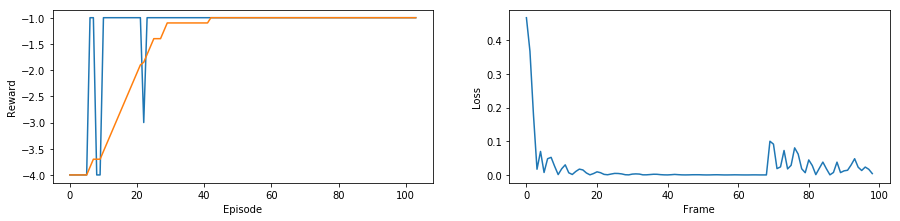

Percentage of success:  0.96
Complete


In [43]:
from tqdm import tqdm
for i in tqdm(range(1000)):
    agent.play()
    plot_durations(agent, 20)
    
    res = (np.array(agent.rewards_log[-100:]) > -4).mean()
    print("Percentage of success: ", res)
    if i > 100 and res > 0.95:
        break

print('Complete')
plt.show()

### Проверка адекватности

In [44]:
def check_value_function():
    s = rubik.reset()
    return agent.policy_net(Tensor(s)[None])

In [45]:
check_value_function()

tensor([[-3.0256, -2.9902, -3.0056, -3.0267, -2.9842, -1.0000, -3.0295, -3.0535,
         -2.9786, -3.0285, -2.9349, -2.9891]],
       device='cuda:0', grad_fn=<ThAddBackward>)

### Стирание памяти при переходе на следующий уровень 
(обнуление frames_done нужно для буфера с приоритетами)

In [46]:
def reset(agent):
    agent.buffer = []
    agent.pos = 0
    agent.priorities = []
    agent.frames_done = 0
    agent.last_game_end = 0 

## Уровень 2

In [47]:
reset(agent)

In [48]:
rubik.complexity, rubik.limit = 2, 4

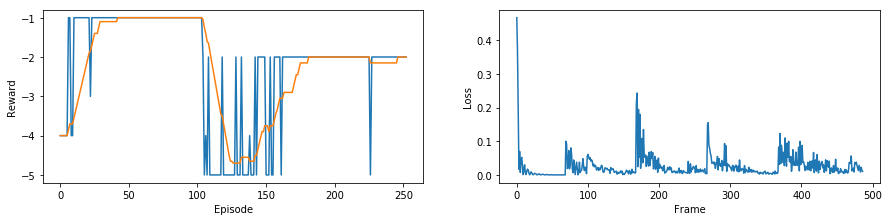

Percentage of success:  0.96
Complete


In [49]:
for i in tqdm(range(2000)):
    agent.play()
    plot_durations(agent, 20)
    
    res = (np.array(agent.rewards_log[-100:]) > -5).mean()
    print("Percentage of success: ", res)
    if i > 100 and res > 0.95:
        break

print('Complete')
plt.show()

# Уровень 3

In [50]:
reset(agent)

In [51]:
rubik.complexity, rubik.limit = 3, 6

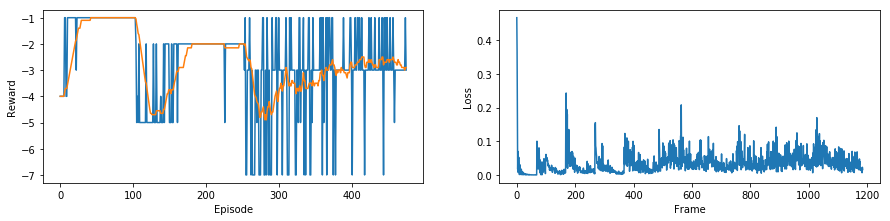

Percentage of success:  0.96
Complete


In [52]:
for i in tqdm(range(2000)):
    agent.play()
    plot_durations(agent, 20)
    
    res = (np.array(agent.rewards_log[-100:]) > -7).mean()
    print("Percentage of success: ", res)
    if i > 100 and res > 0.95:
        break

print('Complete')
plt.show()

# Уровень 4

In [53]:
reset(agent)

In [54]:
rubik.complexity, rubik.limit = 4, 8

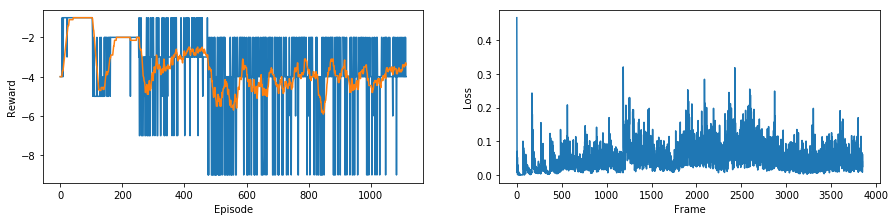

Percentage of success:  0.96
Complete


In [55]:
for i in tqdm(range(2000)):
    agent.play()
    plot_durations(agent, 20)
    
    res = (np.array(agent.rewards_log[-100:]) > -9).mean()
    print("Percentage of success: ", res)
    if i > 100 and res > 0.95:
        break

print('Complete')
plt.show()

# Уровень 5

Важно! Добивал до 0.96 за... 4000 итераций!

In [56]:
reset(agent)

In [57]:
rubik.complexity, rubik.limit = 5, 10

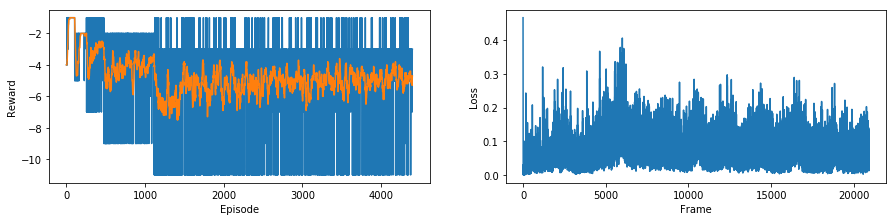

Percentage of success:  0.96
Complete


In [61]:
for i in tqdm(range(2000)):
    agent.play()
    plot_durations(agent, 20)
    
    res = (np.array(agent.rewards_log[-100:]) > -11).mean()
    print("Percentage of success: ", res)
    if i > 100 and res > 0.95:
        break

print('Complete')
plt.show()

In [62]:
from IPython.display import Audio, display
def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

In [63]:
allDone()

# Мечты

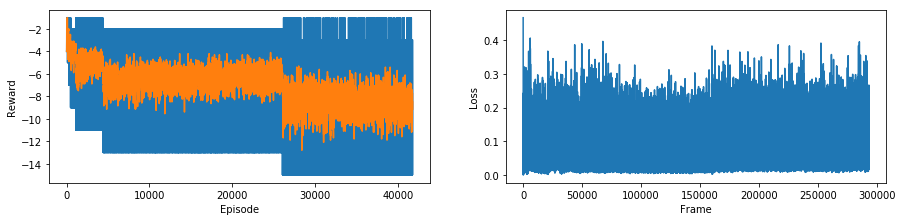

Percentage of success:  0.64













 78%|████████████████████████▎      | 15684/20000 [10:28:42<2:53:00,  2.41s/it]

KeyboardInterrupt: 

In [67]:
level_results = []
for level in range(6, 25):
    rubik.complexity, rubik.limit = level, 2*level
    
    reset(agent)
    
    for i in tqdm(range(20000)):
        agent.play()
        plot_durations(agent, 20)

        res = (np.array(agent.rewards_log[-100:]) > -2*level - 1).mean()
        print("Percentage of success: ", res)
        if i > 100 and res > 0.95:
            break
    
    level_results.append(res)
        
print('Complete')
plt.show()

In [68]:
level_results

[0.86]

# Результаты:
5 уровень - 0.83 за 2000 итераций; 0.96 за 4000

6 уровень - 0.73 за 20 000 итераций добить можно до 0.86

7 уровень - 0.56

8 уровень - 0.59

9 уровень - 0.38

10 уровень - 0.23


# Результаты с HER:
3 уровень - 0.91

4 уровень - 0.8

5 уровень - 0.52

6 уровень - 0.36

7 уровень - 0.15

In [61]:
rubik.complexity, rubik.limit = 10, 100

In [62]:
agent.play(learn=False)

-101

# Баг-тест

In [56]:
state_b, action_b, reward_b, next_state_b, done_b, weights_b = agent.sample(32)

state_b      = Tensor(np.float32(state_b))
next_state_b = Tensor(np.float32(next_state_b))
action_b     = LongTensor(action_b)
reward_b     = Tensor(reward_b)
done_b       = Tensor(done_b)
weights_b    = Tensor(weights_b)

In [57]:
agent.policy_net.train()
q_values      = agent.policy_net.gather(agent.policy_net(state_b), action_b)
q_values

tensor([-7.1425, -1.0255, -3.3588, -6.5061, -3.1376, -6.2340, -4.0532, -4.1573,
        -3.5283, -3.1234, -1.1280, -3.9515, -3.1060, -4.5800, -4.8566, -6.8431,
        -2.1604, -1.0062, -3.9884, -5.9205, -5.8650, -4.1988, -4.2554, -4.2196,
        -2.1604, -5.0530, -3.1248, -5.2834, -3.5283, -4.5803, -1.1394, -6.0677],
       device='cuda:0', grad_fn=<SqueezeBackward1>)

In [58]:
target_q_values = agent.batch_target(reward_b, next_state_b, done_b)
target_q_values

tensor([-7.3629, -1.0000, -3.2243, -6.4194, -3.1102, -6.3907, -3.9234, -4.1374,
        -3.5592, -3.1102, -1.0000, -4.0920, -3.1102, -4.6290, -4.4378, -6.9361,
        -5.8679, -1.0000, -4.0124, -6.1515, -5.7214, -4.0933, -4.4296, -4.1503,
        -2.0000, -5.4247, -3.1102, -5.6587, -3.1102, -4.7296, -1.0000, -6.1704],
       device='cuda:0', grad_fn=<ThAddBackward>)

In [59]:
for i in range(32):
    ns = next_states(state_b[i:i+1])[0][0]
    for j in range(12):
        if (ns[j] != next_state_b[i:i+1]).max() == 0:
            break
    else:
        print("problem!")

problem!
problem!
problem!
problem!
problem!
problem!
problem!
problem!
problem!
problem!
problem!
problem!
problem!
problem!
problem!
problem!
problem!
problem!
problem!
problem!
problem!
problem!
problem!


KeyboardInterrupt: 

# Динамическое изменение уровней

In [85]:
def plot_with_levels(agent, levels, means_window=100):
    """plot agent logs"""    
    clear_output(wait=True)
    
    plt.figure(2, figsize=(15, 7))
    plt.title('Training...')
    
    plt.subplot(221)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(agent.rewards_log)
    plt.plot(sliding_average(agent.rewards_log, means_window))
    
    if hasattr(agent, 'loss_log'):
        plt.subplot(222)
        plt.xlabel('Frame')
        plt.ylabel('Loss')
        plt.plot(agent.loss_log)
        
    if hasattr(agent, 'magnitude_log'):
        plt.subplot(223)
        plt.xlabel('Frame')
        plt.ylabel('Noise Average Magnitude')
        plt.plot(agent.magnitude_log)
        
    plt.subplot(224)
    plt.xlabel('Episode')
    plt.ylabel('Level')
    plt.plot(levels)
    
    plt.show()

In [65]:
levels = []
level = 1
checkpoint = 0

In [68]:
from tqdm import tqdm
for i in tqdm(range(1000)):
    rubik.complexity, rubik.limit = level, 2*level+1
    levels.append(level)
    
    agent.play()
    plot_with_levels(agent, levels, 20)
    
    if len(agent.rewards_log[checkpoint:]) > 30:
        if (np.array(agent.rewards_log[checkpoint:][-100:]) >= -2*level - 1).mean() > 0.55:
            level += 1
            checkpoint = len(agent.rewards_log)
        if level > 1 and (np.array(agent.rewards_log[checkpoint:][-100:]) >= -2*level - 1).mean() < 0.45:
            level -= 1
            checkpoint = len(agent.rewards_log)

print('Complete')
plt.show()

KeyboardInterrupt: 